# Exploratory Data Analysis for the Food Nutrients Data

## Description

Clean fetched FDC datasets contatining nutritional information about various products and explore them.

## Table of Contents

## Results summary

## Imports

In [57]:
import os
import sys

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

sys.path.append(os.path.abspath('..'))
import src.data.utils as utils

## Data source / References

The data was obtained from [Food Data Central](https://fdc.nal.usda.gov/) (Department of Agriculture, USA). The database contains nutritional information about various products and is divided into a few sections (Foundational Foods, most recent; SR (Standard Reference) Legacy, Survey and Branded Foods). The data was fetched using "SR Legacy" type. More complete decription of the database and its contents can be found in [Foundation Foods documentation](https://fdc.nal.usda.gov/docs/Foundation_Foods_Documentation_Apr2023.pdf). 

Note: Standard Reference Legacy contains historic data on whole variety of food components including nutrients derived from analyses, calculations, and published literature but has not been updated since April 2018. 

## Outline of data being explored

There are 2 datasets stored as .csv files in /FoodDataAnalysis/data/raw/ directory.

Each of them contains data for particular kind of food (vegetables & fruits). \
Products in each food category are characterized by 10 variables:
- Energy (kcal)
- Protein (g)
- Fat (g)
- Carbohydrate (g)
- Water (g)
- Ash (g)
- Fiber (g)
- Potassium (mg)
- Sodium (mg)
- Magnesium (mg)

Nutritional quantities listed above are expressed in appropriate units per 100 grams.

Datasets ready for analysis are stored in /FoodDataAnalysis/data/processed/ directory.

## Analysis

## Read & clean the data 

In [86]:
import importlib
import src.data.utils as utils
importlib.reload(utils)

<module 'src.data.utils' from '/home/krzysztof/Documents/Programming/SQL/FoodDataAnalysis/src/data/utils.py'>

In [87]:
data = utils.load_data('../data/raw/')
data = utils.choose_foods(data) # Datasets obtained via API contain much unnecessary information (like highly proccesed foods), that need to be filtered
data = utils.add_food_type(data) # Let's add food type for easier categorization
food_df = utils.merge_data(data) # Merge individual dataframes into one 
food_df['Description'] = food_df['Description'].str.replace(r"\(Includes foods for USDA's Food Distribution Program\)",'',regex=True)
new_columns = {'Total lipid (fat)':'Fat','Carbohydrate, by difference':'Carbohydrates','Fiber, total dietary':'Fiber','Potassium, K':'Potassium','Magnesium, Mg':'Magnesium','Sodium, Na':'Sodium'}
food_df.rename(columns=new_columns,inplace=True)
utils.save_final_datasets(data,'../data/processed/')

## EDA

In [88]:
fruits = food_df[food_df['Category'] == 'fruit']
vegs = food_df[food_df['Category'] == 'vegetable']

### Fruits

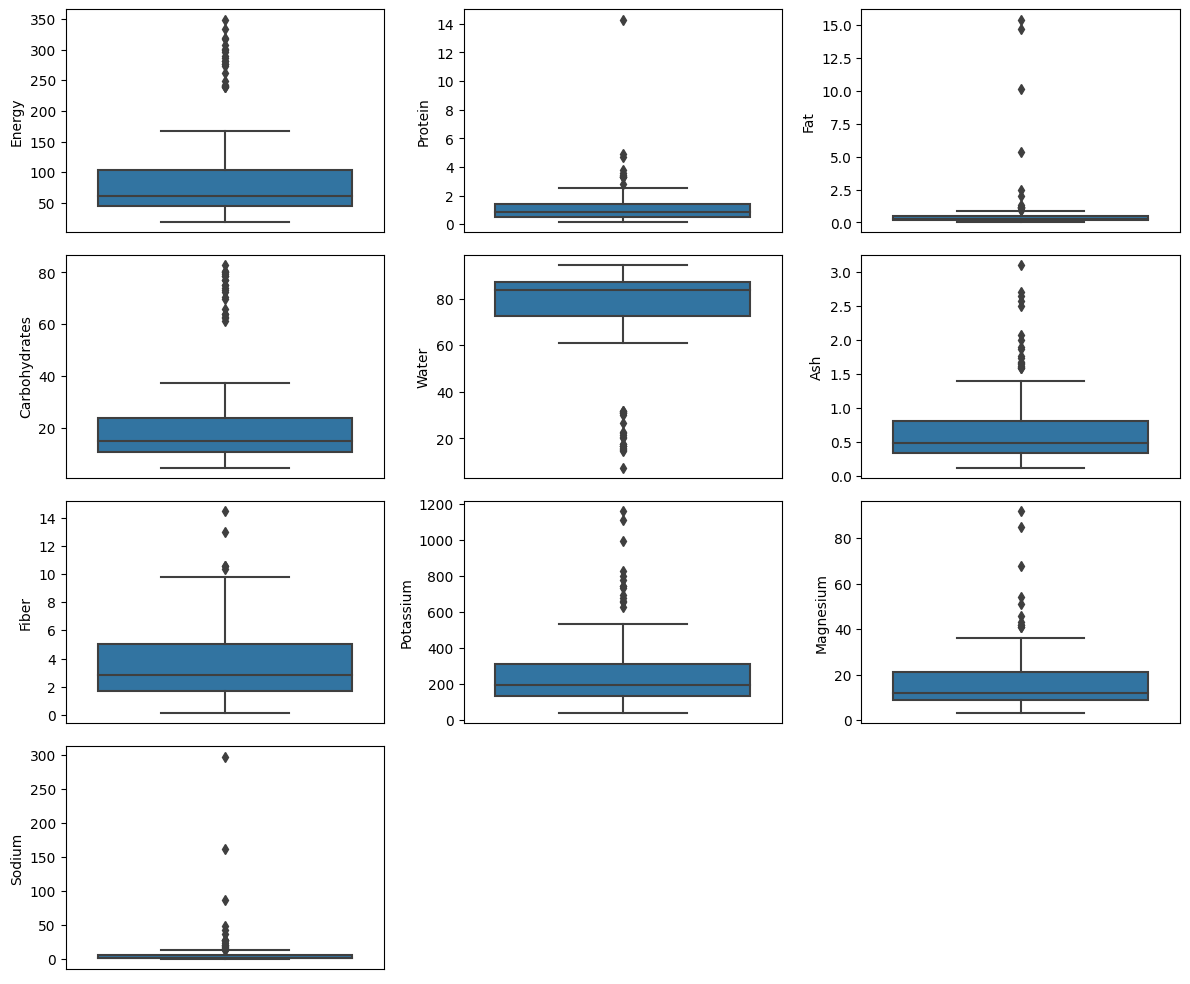

In [61]:
ax = utils.make_distribution_plot(fruits,figsize=(12,10))

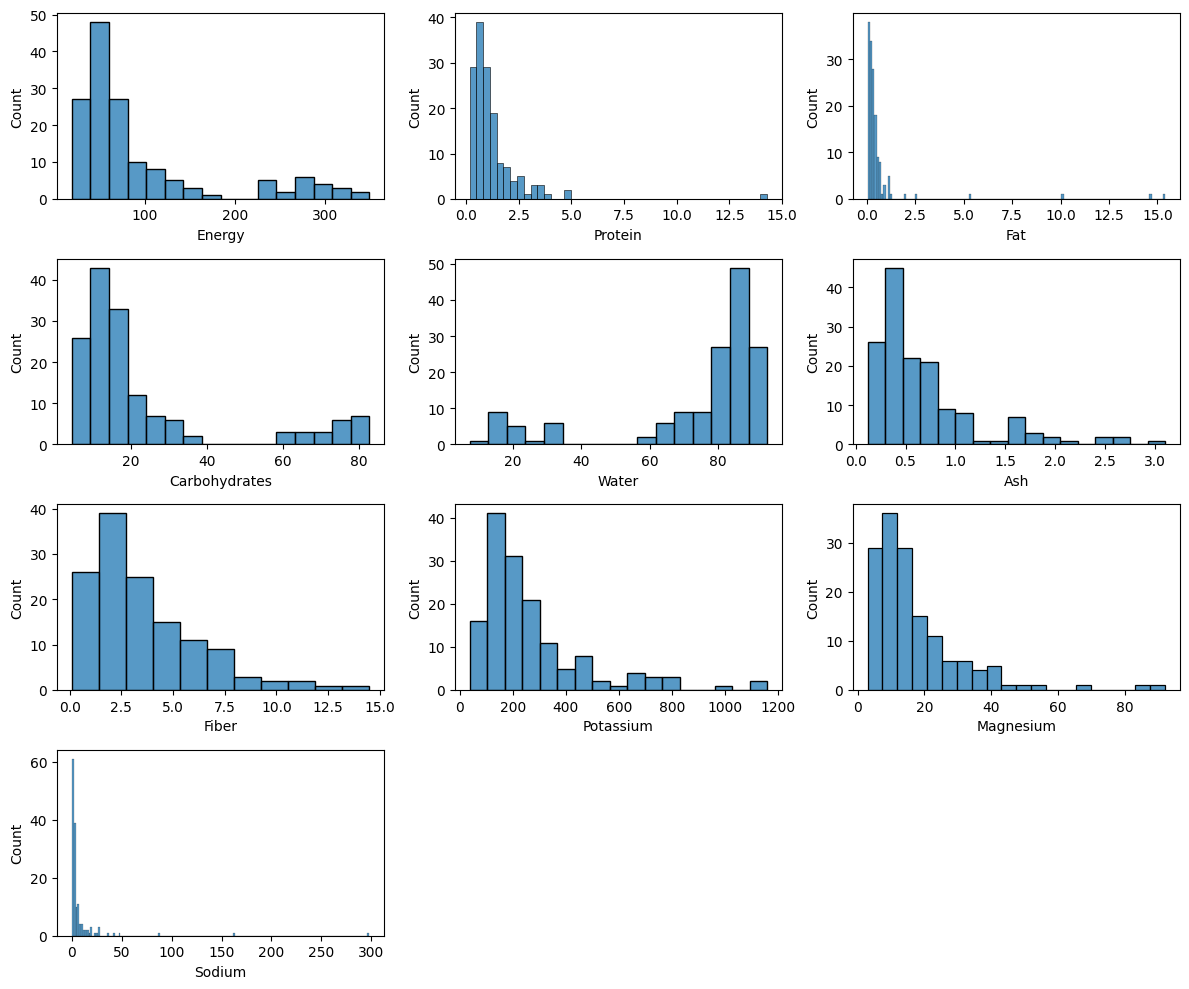

In [62]:
ax = utils.make_distribution_plot(fruits,figsize=(12,10),type='hist',nrows=4)

There are many outliers in the dataset, but they most likely originate from the fact, that the dataset contains both fresh and dried fruits and the latter obviously tend to have greater content of particular nutrients (except water).

Let's confirm this:

In [63]:
fruits_outliers = utils.find_IQR_outliers(fruits)

In [64]:
dried_outlier_summary = utils.count_outlier_dried_fruits(fruits,fruits_outliers)
dried_outlier_summary

,#Dried,%Dried
Energy,16.0,72.7
Protein,8.0,72.7
Fat,5.0,35.7
Carbohydrates,16.0,72.7
Water,16.0,72.7
Ash,9.0,50.0
Fiber,2.0,40.0
Potassium,8.0,57.1
Magnesium,5.0,45.5
Sodium,7.0,36.8


For many quantities (Carbohydrates, Water and Protein in particular) over 50% of outliers are dried fruits. Remaining outliers may be fresh fruits with exceptional levels of particular nutrient.

How many different fruits (without regard to the particular variety) or products (juice) does the dataset contain?

In [82]:
unique_fruit_types = utils.find_unique_food_types(fruits)
print(f'Number of unique types of fruits or products: {len(unique_fruit_types)}')

Number of unique types of fruits or products: 84


Basic summary statistics

In [66]:
fruits.describe()

,Energy,Protein,Fat,Carbohydrates,Water,Ash,Fiber,Potassium,Magnesium,Sodium
count,151.000000,151.000000,151.000000,151.000000,151.000000,151.000000,134.000000,149.000000,147.000000,150.000000
mean,95.039735,1.231921,0.654106,23.511192,73.910596,0.699139,3.555224,269.838926,17.074830,8.633333
std,83.397592,1.389204,1.924030,21.632681,22.945696,0.572220,2.682317,207.383705,14.245926,28.946471
min,19.000000,0.170000,0.040000,4.510000,7.500000,0.120000,0.100000,38.000000,3.000000,0.000000
25%,45.500000,0.540000,0.155000,10.650000,72.400000,0.335000,1.700000,135.000000,9.000000,1.000000
50%,61.000000,0.880000,0.290000,15.000000,83.500000,0.490000,2.800000,197.000000,12.000000,2.000000
75%,103.000000,1.410000,0.465000,23.750000,87.250000,0.810000,5.050000,312.000000,21.000000,6.000000
max,349.000000,14.300000,15.400000,82.800000,94.300000,3.100000,14.500000,1160.000000,92.000000,298.000000


Due to presence of outliers, mean is no longer a good measure of central tendency and median should be used instead. Fruits in the dataset are not abundant in sodium (75th percentile is only 6 mg/100g), although there is also a huge outlier with 298 mg/100g. Many fruits contain quite a lot potassium (median equal to 312 mg / 100g, IQR=177 mg / 100g). Magnesium levels are higher than those of sodium, but still rather low. For certain fruits, certain quantities, such as Fiber or Magnesium, may not be present. According to FDC Documentation, this is because particular nutrient were not measured or doesn't occur naturally for given product.

Upon reviewing the table ("max" statistic), it is evident that extreme values exist for each variable. To further explore, let's identify samples that represent the top 3% of values in each variable 

In [67]:
fruits_top_3_percent = utils.find_top_n_percent_of_samples(fruits,3)

In [68]:
fruits_top_3_percent['Fiber']

,Description,Energy,Protein,Fat,Carbohydrates,Water,Ash,Fiber,Potassium,Magnesium,Sodium,Category
202,"Passion-fruit, (granadilla), purple, raw",97.0,2.20,0.70,23.4,72.9,0.80,10.4,348.0,29.0,28.0,fruit
252,"Goji berries, dried",349.0,14.30,0.39,77.1,7.5,0.78,13.0,NaN,NaN,298.0,fruit
277,"Lemon peel, raw",47.0,1.50,0.30,16.0,81.6,0.60,10.6,160.0,15.0,6.0,fruit
296,"Orange peel, raw",97.0,1.50,0.20,25.0,72.5,0.80,10.6,212.0,22.0,3.0,fruit
316,"Persimmons, japanese, dried",274.0,1.38,0.59,73.4,23.0,1.59,14.5,802.0,31.0,2.0,fruit


In [69]:
fruits_top_3_percent['Fat']

,Description,Energy,Protein,Fat,Carbohydrates,Water,Ash,Fiber,Potassium,Magnesium,Sodium,Category
222,"Avocados, raw, all commercial varieties",160.0,2.00,14.70,8.53,73.2,1.58,6.7,485.0,29.0,7.0,fruit
223,"Avocados, raw, California",167.0,1.96,15.40,8.64,72.3,1.66,6.8,507.0,29.0,8.0,fruit
224,"Avocados, raw, Florida",120.0,2.23,10.10,7.82,78.8,1.08,5.6,351.0,24.0,2.0,fruit
227,"Blueberries, dried, sweetened",317.0,2.50,2.50,80.00,14.8,0.73,7.5,214.0,18.0,3.0,fruit
246,"Durian, raw or frozen",147.0,1.47,5.33,27.10,65.0,1.12,3.8,436.0,30.0,2.0,fruit


In [70]:
fruits_top_3_percent['Protein']

,Description,Energy,Protein,Fat,Carbohydrates,Water,Ash,Fiber,Potassium,Magnesium,Sodium,Category
252,"Goji berries, dried",349.0,14.30,0.39,77.1,7.5,0.78,13.0,NaN,NaN,298.0,fruit
271,"Jujube, Chinese, fresh, dried",281.0,4.72,0.50,72.5,20.2,2.08,6.0,217.0,NaN,5.0,fruit
281,"Litchis, dried",277.0,3.80,1.20,70.7,22.3,2.00,4.6,1110.0,42.0,3.0,fruit
283,"Longans, dried",286.0,4.90,0.40,74.0,17.6,3.10,NaN,658.0,46.0,48.0,fruit
305,"Peaches, dried, sulfured, uncooked",239.0,3.61,0.76,61.3,31.8,2.50,8.2,996.0,42.0,7.0,fruit


### Vegetables

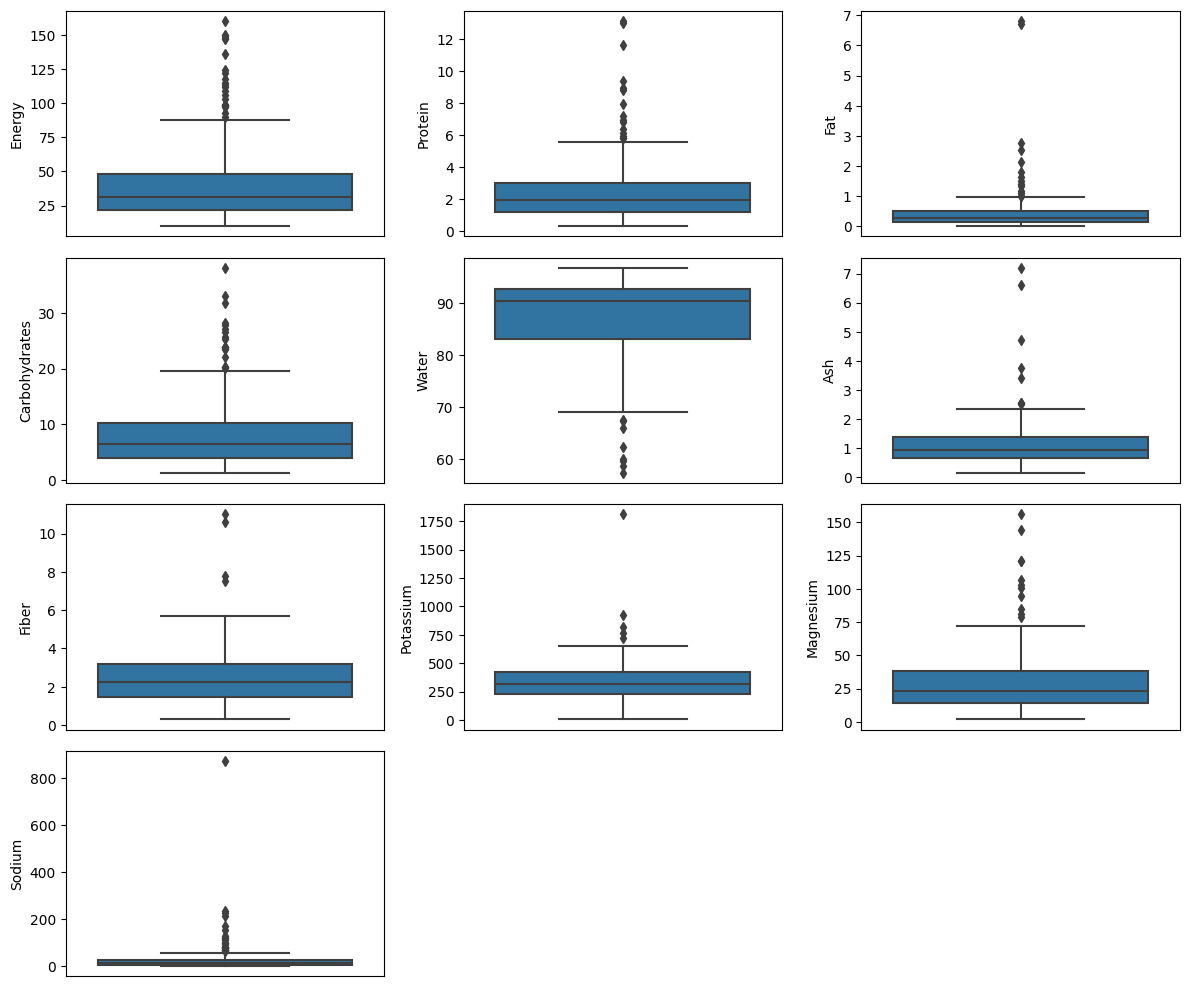

In [84]:
ax = utils.make_distribution_plot(vegs,figsize=(12,10),nrows=4)

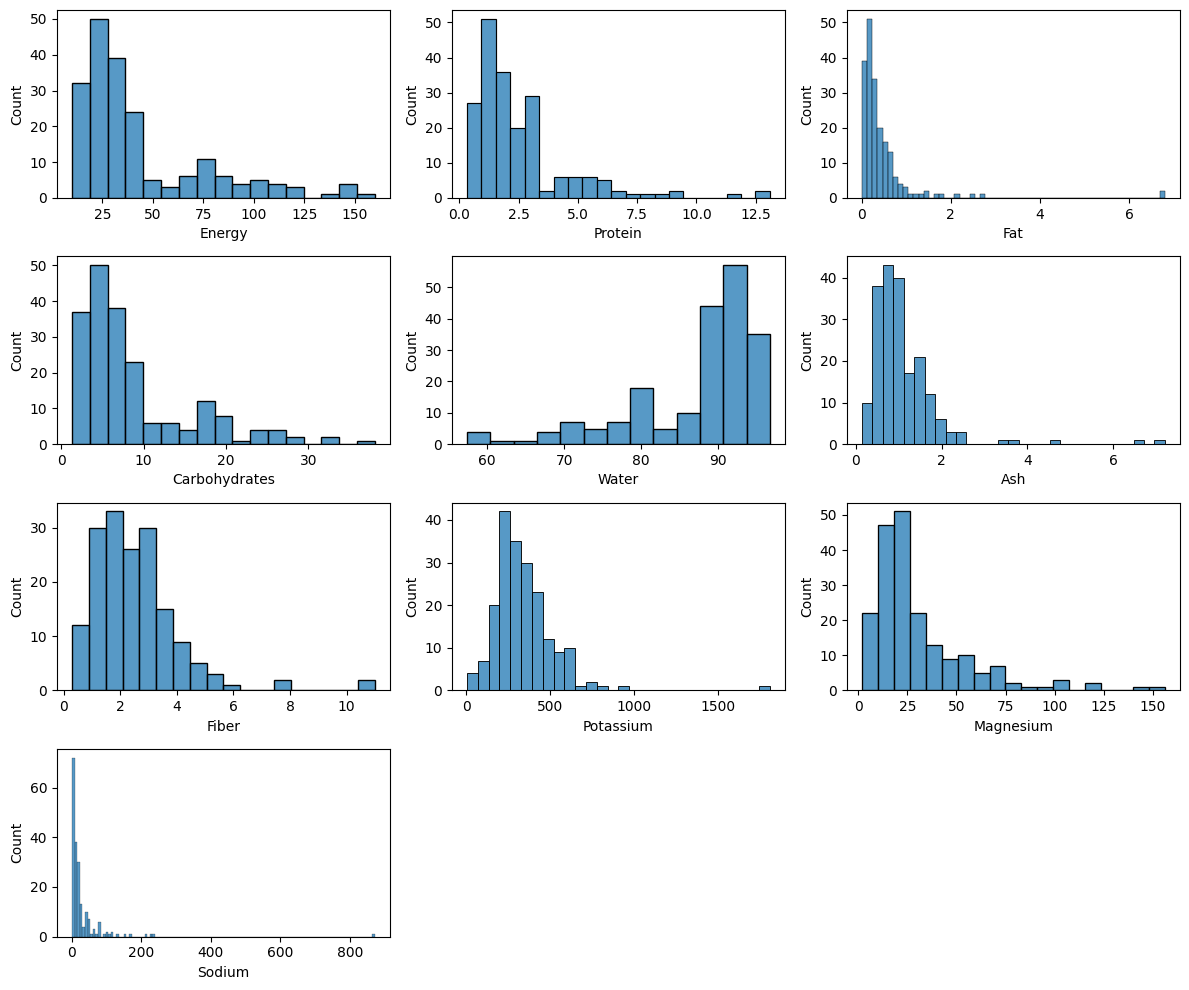

In [85]:
ax = utils.make_distribution_plot(vegs,figsize=(12,10),nrows=4,type='hist')

In [90]:
vegs.describe()

,Energy,Protein,Fat,Carbohydrates,Water,Ash,Fiber,Potassium,Magnesium,Sodium
count,185.00000,185.000000,185.000000,185.000000,185.000000,185.000000,159.000000,185.000000,184.000000,185.000000
mean,41.72973,2.323622,0.382595,8.700973,87.472973,1.120541,2.420126,344.362162,30.016304,30.800000
std,31.43735,1.732791,0.404792,7.126078,8.312270,0.860423,1.565886,187.477401,25.126233,72.651626
min,10.00000,0.330000,0.010000,1.290000,57.400000,0.150000,0.300000,6.000000,2.000000,1.000000
25%,22.00000,1.200000,0.160000,3.700000,85.000000,0.640000,1.350000,233.000000,13.750000,5.000000
50%,31.00000,1.870000,0.280000,6.100000,90.500000,0.910000,2.200000,320.000000,22.000000,13.000000
75%,45.00000,2.950000,0.440000,9.560000,92.800000,1.370000,3.100000,420.000000,37.000000,27.000000
max,160.00000,11.600000,2.750000,38.100000,96.700000,7.200000,11.000000,1810.000000,156.000000,872.000000


Vegetables in the dataset contain low amounts of carbohydrates, protein and fat. Just like fruits, they have a high potassium content. Like in the case of fruits, there are also many outliers in the dataset containing vegetables. 

Let's investigate them:

In [99]:
vegs_outliers = utils.find_IQR_outliers(vegs)
vegs.loc[vegs_outliers['Sodium']].sort_values(by='Sodium',ascending=False).head()

,Description,Energy,Protein,Fat,Carbohydrates,Water,Ash,Fiber,Potassium,Magnesium,Sodium,Category
146,"Seaweed, wakame, raw",45.0,3.03,0.64,9.14,80.0,7.20,0.5,50.0,107.0,872.0,vegetable
143,"Seaweed, kelp, raw",43.0,1.68,0.56,9.57,81.6,6.61,1.3,89.0,121.0,233.0,vegetable
11,"Beet greens, raw",22.0,2.20,0.13,4.33,91.0,2.33,3.7,762.0,70.0,226.0,vegetable
39,"Chard, swiss, raw",19.0,1.80,0.20,3.74,92.7,1.60,1.6,379.0,81.0,213.0,vegetable
30,"Cardoon, raw",17.0,0.70,0.10,4.07,94.0,1.13,1.6,400.0,42.0,170.0,vegetable


## Conclusions